# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [12]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

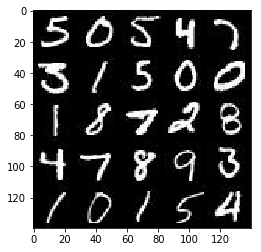

In [13]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

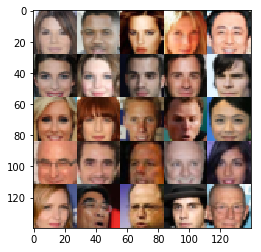

In [14]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [15]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.0.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [16]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    real_input = tf.placeholder(tf.float32,[None,image_width,image_height,image_channels])
    z = tf.placeholder(tf.float32,[None,z_dim])
    learning_rate = tf.placeholder(tf.float32)

    return real_input,z,learning_rate #None, None, None


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [17]:
def discriminator(images, reuse=False,alpha=0.01):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    n_filter = 16 #16
    filter_size = 5
    with tf.variable_scope('discriminator', reuse=reuse):
        # Input layer is 32x32x3 28x28x3
        #Conv1 16x16x16 14x14x16
        z1= tf.layers.conv2d(images,n_filter,filter_size,(2,2),padding='same')
        #leaky relu
        y1 = tf.maximum(alpha*z1,z1)
        
        print("size of conv1 is ",y1.shape)
        
        #Conv2 8x8x32 7x7x32
        z2= tf.layers.conv2d(y1,n_filter*2,filter_size,(2,2),padding='same')
        bn2 = tf.layers.batch_normalization(z2, training=True)
        #leaky relu
        y2 = tf.maximum(alpha*bn2,bn2)
        
        #Conv3 4x4x64 
        z3= tf.layers.conv2d(y2,n_filter*4,filter_size,(2,2),padding='same')
        bn3 = tf.layers.batch_normalization(z3, training=True)
        #leaky relu
        y3 = tf.maximum(alpha*bn3,bn3)        
        print("size of conv3 is ",y3.shape)
        
        #Conv4 4x4x128 
        ##z4= tf.layers.conv2d(y3,n_filter*4*2,filter_size,(1,1),padding='same')
        #bn4 = tf.layers.batch_normalization(z4, training=True)
        #leaky relu
        #y4 = tf.maximum(alpha*z4,z4)        
        #print("size of conv4 is ",y4.shape)
        
        # Flatten it
        flat = tf.reshape(y3, (-1, 4*4*n_filter*4*2))
        logits = tf.layers.dense(flat,1)
        out = tf.sigmoid(logits) 
        
    return out,logits 


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

size of conv1 is  (?, 14, 14, 16)
size of conv3 is  (?, 4, 4, 64)
size of conv1 is  (?, 14, 14, 16)
size of conv3 is  (?, 4, 4, 64)
Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [18]:
def generator(z, out_channel_dim,is_train=True,alpha=0.01):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    reuse=not is_train
    training=is_train
    n_filters=512 #1024 #512

    # TODO: Implement Function
    with tf.variable_scope('generator', reuse=reuse):
        print("size of z is ", z.shape)
        # First fully connected layer
        x=tf.layers.dense(z,7*7*n_filters,activation=None)
        #Reshape  7x7x512
        x_reshape = tf.reshape(x,(-1,7,7,n_filters))
        bn1 = tf.layers.batch_normalization(x_reshape, training=training)
        #leaky relu
        y1 = tf.maximum(alpha*bn1,bn1)
        print("Size of layer 1",y1.shape)
       
        #Conv2 14x14x256
        z3= tf.layers.conv2d_transpose(y1,int(n_filters/2),(5,5),(2,2),padding='same')
        bn3 = tf.layers.batch_normalization(z3, training=training)
        #leaky relu
        y3 = tf.maximum(alpha*bn3,bn3)
        
        #Conv2 28x28x128
        #z4= tf.layers.conv2d_transpose(y3,int(n_filters/4),(5,5),(2,2),padding='same')
        #bn4 = tf.layers.batch_normalization(z4, training=training)
        #leaky relu
        #y4 = tf.maximum(alpha*bn4,bn4)
        
        # Output layer, 28x28x3
        logits = tf.layers.conv2d_transpose(y3,out_channel_dim,(5,5),(2,2),padding='same')
        print("size of output is ",logits.shape)
        out = tf.tanh(logits)
        #print(out.shape)
    return out    
    #return None


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

size of z is  (?, 100)
Size of layer 1 (?, 7, 7, 512)
size of output is  (?, 28, 28, 5)
True
call('generator', reuse=False)
size of z is  (?, 100)
Size of layer 1 (?, 7, 7, 512)
size of output is  (?, 28, 28, 5)
True
call('generator', reuse=True)
Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [19]:
def model_loss(input_real, input_z, out_channel_dim,alpha=0.01):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    
    smooth = 0.1
    g_model = generator(input_z, out_channel_dim, alpha=alpha)
    d_model_real, d_logits_real = discriminator(input_real, alpha=alpha)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True, alpha=alpha)

    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real)*(1-smooth)))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))

    d_loss = d_loss_real + d_loss_fake

    return d_loss, g_loss
"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

size of z is  (?, 100)
Size of layer 1 (?, 7, 7, 512)
size of output is  (?, 28, 28, 4)
size of conv1 is  (?, 14, 14, 16)
size of conv3 is  (?, 4, 4, 64)
size of conv1 is  (?, 14, 14, 16)
size of conv3 is  (?, 4, 4, 64)
Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [20]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    # Get weights and bias to update
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)

    return d_train_opt, g_train_opt

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [21]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [22]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    n_images=25
    alpha = 0.2 #01
    print_every=10
    show_every=100
    figsize=(5,5)
    steps=0
    samples, losses = [], []
    # TODO: Build Model
    tf.reset_default_graph()

    print('data_shape',data_shape)
    input_real, input_z, learning_rate_z = model_inputs(data_shape[1],data_shape[2],data_shape[3], z_dim)

    d_loss, g_loss = model_loss(input_real, input_z, data_shape[3], alpha=alpha)

    d_opt, g_opt = model_opt(d_loss, g_loss, learning_rate_z, beta1)
    
    saver = tf.train.Saver()

    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                steps += 1

                # Sample random noise for G
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))

                # Run optimizers
                _ = sess.run(d_opt, feed_dict={input_real: batch_images, input_z: batch_z,learning_rate_z:learning_rate})
                _ = sess.run(g_opt, feed_dict={input_z: batch_z, input_real: batch_images,learning_rate_z:learning_rate})
                
                if steps % print_every == 0:
                    # At the end of each epoch, get the losses and print them out
                    train_loss_d = d_loss.eval({input_z: batch_z, input_real: batch_images})
                    train_loss_g = g_loss.eval({input_z: batch_z})

                    print("Samples used {}".format(steps*batch_size),
                          "Epoch {}/{}...".format(epoch_i+1, epoch_count),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                    # Save losses to view after training
                    losses.append((train_loss_d, train_loss_g)) 
                    
                if steps % show_every == 0:
                    #np.random.seed(0)
                    show_generator_output(sess, n_images, input_z, data_shape[3], data_image_mode)

        #saver.save(sess, './checkpoints/generator.ckpt')
    print("Done with the training..Enjoy your pictures")
    #return None

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

data_shape (60000, 28, 28, 1)
size of z is  (?, 100)
Size of layer 1 (?, 7, 7, 512)
size of output is  (?, 28, 28, 1)
size of conv1 is  (?, 14, 14, 16)
size of conv3 is  (?, 4, 4, 64)
size of conv1 is  (?, 14, 14, 16)
size of conv3 is  (?, 4, 4, 64)
Samples used 1280 Epoch 1/2... Discriminator Loss: 3.0484... Generator Loss: 0.1216
Samples used 2560 Epoch 1/2... Discriminator Loss: 3.3177... Generator Loss: 0.0992
Samples used 3840 Epoch 1/2... Discriminator Loss: 2.9398... Generator Loss: 0.1961
Samples used 5120 Epoch 1/2... Discriminator Loss: 2.5408... Generator Loss: 0.2882
Samples used 6400 Epoch 1/2... Discriminator Loss: 2.3900... Generator Loss: 0.3247
Samples used 7680 Epoch 1/2... Discriminator Loss: 2.1359... Generator Loss: 0.4062
Samples used 8960 Epoch 1/2... Discriminator Loss: 2.0127... Generator Loss: 0.4525
Samples used 10240 Epoch 1/2... Discriminator Loss: 1.8135... Generator Loss: 0.5153
Samples used 11520 Epoch 1/2... Discriminator Loss: 1.8039... Generator Loss:

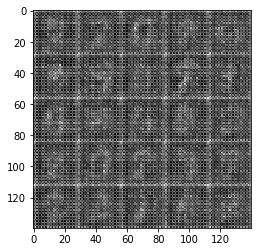

Samples used 14080 Epoch 1/2... Discriminator Loss: 1.7335... Generator Loss: 0.5672
Samples used 15360 Epoch 1/2... Discriminator Loss: 1.5918... Generator Loss: 0.6070
Samples used 16640 Epoch 1/2... Discriminator Loss: 1.7316... Generator Loss: 0.5759
Samples used 17920 Epoch 1/2... Discriminator Loss: 1.6018... Generator Loss: 0.6261
Samples used 19200 Epoch 1/2... Discriminator Loss: 1.5538... Generator Loss: 0.6564
Samples used 20480 Epoch 1/2... Discriminator Loss: 1.5455... Generator Loss: 0.6536
Samples used 21760 Epoch 1/2... Discriminator Loss: 1.4936... Generator Loss: 0.6984
Samples used 23040 Epoch 1/2... Discriminator Loss: 1.4814... Generator Loss: 0.6794
Samples used 24320 Epoch 1/2... Discriminator Loss: 1.4494... Generator Loss: 0.7079
Samples used 25600 Epoch 1/2... Discriminator Loss: 1.4082... Generator Loss: 0.7322
size of z is  (?, 100)
Size of layer 1 (?, 7, 7, 512)
size of output is  (?, 28, 28, 1)


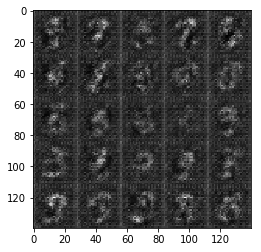

Samples used 26880 Epoch 1/2... Discriminator Loss: 1.4005... Generator Loss: 0.7129
Samples used 28160 Epoch 1/2... Discriminator Loss: 1.3962... Generator Loss: 1.0188
Samples used 29440 Epoch 1/2... Discriminator Loss: 1.2067... Generator Loss: 0.6722
Samples used 30720 Epoch 1/2... Discriminator Loss: 1.1035... Generator Loss: 1.6609
Samples used 32000 Epoch 1/2... Discriminator Loss: 0.9545... Generator Loss: 0.8926
Samples used 33280 Epoch 1/2... Discriminator Loss: 0.7413... Generator Loss: 1.5156
Samples used 34560 Epoch 1/2... Discriminator Loss: 0.8056... Generator Loss: 2.0994
Samples used 35840 Epoch 1/2... Discriminator Loss: 0.6497... Generator Loss: 3.2186
Samples used 37120 Epoch 1/2... Discriminator Loss: 0.8217... Generator Loss: 1.8012
Samples used 38400 Epoch 1/2... Discriminator Loss: 1.1501... Generator Loss: 0.6645
size of z is  (?, 100)
Size of layer 1 (?, 7, 7, 512)
size of output is  (?, 28, 28, 1)


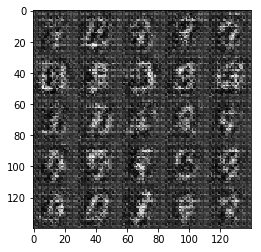

Samples used 39680 Epoch 1/2... Discriminator Loss: 0.8513... Generator Loss: 3.2129
Samples used 40960 Epoch 1/2... Discriminator Loss: 0.7129... Generator Loss: 4.0779
Samples used 42240 Epoch 1/2... Discriminator Loss: 0.7516... Generator Loss: 3.3560
Samples used 43520 Epoch 1/2... Discriminator Loss: 0.9094... Generator Loss: 0.9231
Samples used 44800 Epoch 1/2... Discriminator Loss: 1.2139... Generator Loss: 4.7476
Samples used 46080 Epoch 1/2... Discriminator Loss: 1.8400... Generator Loss: 0.2695
Samples used 47360 Epoch 1/2... Discriminator Loss: 1.0565... Generator Loss: 0.8276
Samples used 48640 Epoch 1/2... Discriminator Loss: 0.7639... Generator Loss: 2.9128
Samples used 49920 Epoch 1/2... Discriminator Loss: 0.5434... Generator Loss: 1.8229
Samples used 51200 Epoch 1/2... Discriminator Loss: 0.6534... Generator Loss: 1.6203
size of z is  (?, 100)
Size of layer 1 (?, 7, 7, 512)
size of output is  (?, 28, 28, 1)


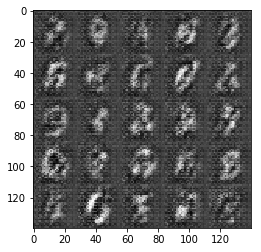

Samples used 52480 Epoch 1/2... Discriminator Loss: 1.0947... Generator Loss: 1.2348
Samples used 53760 Epoch 1/2... Discriminator Loss: 0.9680... Generator Loss: 2.1528
Samples used 55040 Epoch 1/2... Discriminator Loss: 1.1343... Generator Loss: 0.6823
Samples used 56320 Epoch 1/2... Discriminator Loss: 0.8129... Generator Loss: 1.0740
Samples used 57600 Epoch 1/2... Discriminator Loss: 1.0011... Generator Loss: 3.8020
Samples used 58880 Epoch 1/2... Discriminator Loss: 0.9044... Generator Loss: 1.9052
Samples used 60160 Epoch 2/2... Discriminator Loss: 0.6770... Generator Loss: 2.0226
Samples used 61440 Epoch 2/2... Discriminator Loss: 0.5357... Generator Loss: 3.0912
Samples used 62720 Epoch 2/2... Discriminator Loss: 1.1690... Generator Loss: 0.6065
Samples used 64000 Epoch 2/2... Discriminator Loss: 0.5590... Generator Loss: 2.9203
size of z is  (?, 100)
Size of layer 1 (?, 7, 7, 512)
size of output is  (?, 28, 28, 1)


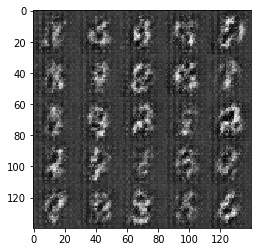

Samples used 65280 Epoch 2/2... Discriminator Loss: 1.1075... Generator Loss: 0.6640
Samples used 66560 Epoch 2/2... Discriminator Loss: 1.5753... Generator Loss: 0.4830
Samples used 67840 Epoch 2/2... Discriminator Loss: 1.0960... Generator Loss: 1.0255
Samples used 69120 Epoch 2/2... Discriminator Loss: 0.8728... Generator Loss: 2.0304
Samples used 70400 Epoch 2/2... Discriminator Loss: 0.8657... Generator Loss: 1.0166
Samples used 71680 Epoch 2/2... Discriminator Loss: 0.7889... Generator Loss: 1.1485
Samples used 72960 Epoch 2/2... Discriminator Loss: 0.4984... Generator Loss: 2.6419
Samples used 74240 Epoch 2/2... Discriminator Loss: 1.0517... Generator Loss: 0.7285
Samples used 75520 Epoch 2/2... Discriminator Loss: 0.6556... Generator Loss: 1.4815
Samples used 76800 Epoch 2/2... Discriminator Loss: 0.7039... Generator Loss: 1.3055
size of z is  (?, 100)
Size of layer 1 (?, 7, 7, 512)
size of output is  (?, 28, 28, 1)


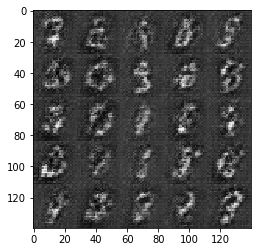

Samples used 78080 Epoch 2/2... Discriminator Loss: 0.7948... Generator Loss: 1.8851
Samples used 79360 Epoch 2/2... Discriminator Loss: 0.9322... Generator Loss: 1.1011
Samples used 80640 Epoch 2/2... Discriminator Loss: 0.7637... Generator Loss: 1.2413
Samples used 81920 Epoch 2/2... Discriminator Loss: 0.4170... Generator Loss: 2.8894
Samples used 83200 Epoch 2/2... Discriminator Loss: 0.8936... Generator Loss: 2.7112
Samples used 84480 Epoch 2/2... Discriminator Loss: 1.3110... Generator Loss: 0.5123
Samples used 85760 Epoch 2/2... Discriminator Loss: 1.6091... Generator Loss: 1.5792
Samples used 87040 Epoch 2/2... Discriminator Loss: 0.9558... Generator Loss: 2.0907
Samples used 88320 Epoch 2/2... Discriminator Loss: 0.5359... Generator Loss: 2.8188
Samples used 89600 Epoch 2/2... Discriminator Loss: 1.1129... Generator Loss: 0.6472
size of z is  (?, 100)
Size of layer 1 (?, 7, 7, 512)
size of output is  (?, 28, 28, 1)


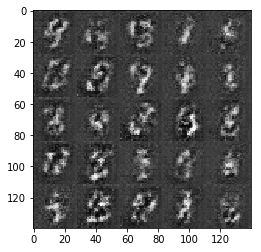

Samples used 90880 Epoch 2/2... Discriminator Loss: 0.4040... Generator Loss: 3.0031
Samples used 92160 Epoch 2/2... Discriminator Loss: 0.5981... Generator Loss: 5.6085
Samples used 93440 Epoch 2/2... Discriminator Loss: 0.5808... Generator Loss: 3.5233
Samples used 94720 Epoch 2/2... Discriminator Loss: 0.3974... Generator Loss: 3.7998
Samples used 96000 Epoch 2/2... Discriminator Loss: 0.7328... Generator Loss: 1.4450
Samples used 97280 Epoch 2/2... Discriminator Loss: 0.7314... Generator Loss: 1.2303
Samples used 98560 Epoch 2/2... Discriminator Loss: 0.4263... Generator Loss: 2.5825
Samples used 99840 Epoch 2/2... Discriminator Loss: 0.8141... Generator Loss: 2.7671
Samples used 101120 Epoch 2/2... Discriminator Loss: 0.6901... Generator Loss: 1.2995
Samples used 102400 Epoch 2/2... Discriminator Loss: 0.6948... Generator Loss: 3.9782
size of z is  (?, 100)
Size of layer 1 (?, 7, 7, 512)
size of output is  (?, 28, 28, 1)


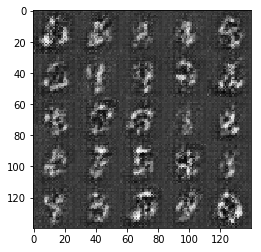

Samples used 103680 Epoch 2/2... Discriminator Loss: 0.5923... Generator Loss: 2.3169
Samples used 104960 Epoch 2/2... Discriminator Loss: 1.0588... Generator Loss: 0.7104
Samples used 106240 Epoch 2/2... Discriminator Loss: 0.4866... Generator Loss: 2.8107
Samples used 107520 Epoch 2/2... Discriminator Loss: 0.4332... Generator Loss: 2.5609
Samples used 108800 Epoch 2/2... Discriminator Loss: 0.5245... Generator Loss: 1.9168
Samples used 110080 Epoch 2/2... Discriminator Loss: 0.3909... Generator Loss: 3.0785
Samples used 111360 Epoch 2/2... Discriminator Loss: 0.3955... Generator Loss: 3.6671
Samples used 112640 Epoch 2/2... Discriminator Loss: 0.4093... Generator Loss: 4.5933
Samples used 113920 Epoch 2/2... Discriminator Loss: 0.5154... Generator Loss: 2.5373
Samples used 115200 Epoch 2/2... Discriminator Loss: 0.9368... Generator Loss: 4.4032
size of z is  (?, 100)
Size of layer 1 (?, 7, 7, 512)
size of output is  (?, 28, 28, 1)


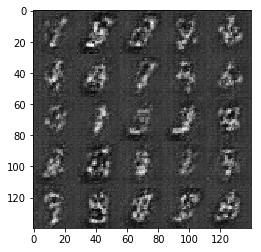

Samples used 116480 Epoch 2/2... Discriminator Loss: 0.3786... Generator Loss: 3.7677
Samples used 117760 Epoch 2/2... Discriminator Loss: 0.6332... Generator Loss: 1.5110
Samples used 119040 Epoch 2/2... Discriminator Loss: 0.6420... Generator Loss: 1.4104
Done with the training..Enjoy your pictures


IndexError: list index out of range

In [23]:
import matplotlib.pyplot as plt

batch_size = 128 #None
z_dim = 100 #None
learning_rate = 0.0003#None
beta1 = 0.5 #None


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

data_shape (202599, 28, 28, 3)
size of z is  (?, 100)
Size of layer 1 (?, 7, 7, 512)
size of output is  (?, 28, 28, 3)
size of conv1 is  (?, 14, 14, 16)
size of conv3 is  (?, 4, 4, 64)
size of conv1 is  (?, 14, 14, 16)
size of conv3 is  (?, 4, 4, 64)
Samples used 1280 Epoch 1/1... Discriminator Loss: 5.2522... Generator Loss: 0.0117
Samples used 2560 Epoch 1/1... Discriminator Loss: 5.4200... Generator Loss: 0.0159
Samples used 3840 Epoch 1/1... Discriminator Loss: 4.4681... Generator Loss: 0.0412
Samples used 5120 Epoch 1/1... Discriminator Loss: 3.9719... Generator Loss: 0.0671
Samples used 6400 Epoch 1/1... Discriminator Loss: 3.5501... Generator Loss: 0.1170
Samples used 7680 Epoch 1/1... Discriminator Loss: 2.9747... Generator Loss: 0.2059
Samples used 8960 Epoch 1/1... Discriminator Loss: 2.6566... Generator Loss: 0.2490
Samples used 10240 Epoch 1/1... Discriminator Loss: 2.3772... Generator Loss: 0.3279
Samples used 11520 Epoch 1/1... Discriminator Loss: 2.3562... Generator Loss

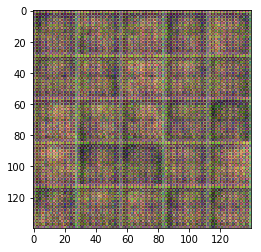

Samples used 14080 Epoch 1/1... Discriminator Loss: 2.1677... Generator Loss: 0.4132
Samples used 15360 Epoch 1/1... Discriminator Loss: 2.0517... Generator Loss: 0.4725
Samples used 16640 Epoch 1/1... Discriminator Loss: 1.9498... Generator Loss: 0.4544
Samples used 17920 Epoch 1/1... Discriminator Loss: 1.9530... Generator Loss: 0.5093
Samples used 19200 Epoch 1/1... Discriminator Loss: 1.9795... Generator Loss: 0.4809
Samples used 20480 Epoch 1/1... Discriminator Loss: 1.9177... Generator Loss: 0.5048
Samples used 21760 Epoch 1/1... Discriminator Loss: 1.8556... Generator Loss: 0.5143
Samples used 23040 Epoch 1/1... Discriminator Loss: 1.8509... Generator Loss: 0.5232
Samples used 24320 Epoch 1/1... Discriminator Loss: 1.7843... Generator Loss: 0.5600
Samples used 25600 Epoch 1/1... Discriminator Loss: 1.7861... Generator Loss: 0.5378
size of z is  (?, 100)
Size of layer 1 (?, 7, 7, 512)
size of output is  (?, 28, 28, 3)


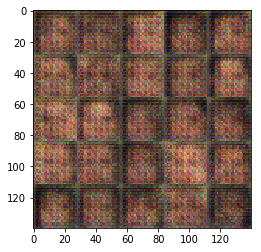

Samples used 26880 Epoch 1/1... Discriminator Loss: 1.7739... Generator Loss: 0.5634
Samples used 28160 Epoch 1/1... Discriminator Loss: 1.7199... Generator Loss: 0.5814
Samples used 29440 Epoch 1/1... Discriminator Loss: 1.7148... Generator Loss: 0.5506
Samples used 30720 Epoch 1/1... Discriminator Loss: 1.6564... Generator Loss: 0.6443
Samples used 32000 Epoch 1/1... Discriminator Loss: 1.7038... Generator Loss: 0.5916
Samples used 33280 Epoch 1/1... Discriminator Loss: 1.6366... Generator Loss: 0.6123
Samples used 34560 Epoch 1/1... Discriminator Loss: 1.6628... Generator Loss: 0.5874
Samples used 35840 Epoch 1/1... Discriminator Loss: 1.5957... Generator Loss: 0.6466
Samples used 37120 Epoch 1/1... Discriminator Loss: 1.5948... Generator Loss: 0.6264
Samples used 38400 Epoch 1/1... Discriminator Loss: 1.6449... Generator Loss: 0.6314
size of z is  (?, 100)
Size of layer 1 (?, 7, 7, 512)
size of output is  (?, 28, 28, 3)


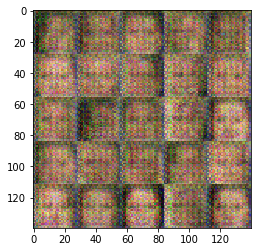

Samples used 39680 Epoch 1/1... Discriminator Loss: 1.6285... Generator Loss: 0.6183
Samples used 40960 Epoch 1/1... Discriminator Loss: 1.6072... Generator Loss: 0.6316
Samples used 42240 Epoch 1/1... Discriminator Loss: 1.5539... Generator Loss: 0.6923
Samples used 43520 Epoch 1/1... Discriminator Loss: 1.5592... Generator Loss: 0.6770
Samples used 44800 Epoch 1/1... Discriminator Loss: 1.5115... Generator Loss: 0.6867
Samples used 46080 Epoch 1/1... Discriminator Loss: 1.4568... Generator Loss: 0.7352
Samples used 47360 Epoch 1/1... Discriminator Loss: 1.4374... Generator Loss: 0.7094
Samples used 48640 Epoch 1/1... Discriminator Loss: 1.4014... Generator Loss: 0.7650
Samples used 49920 Epoch 1/1... Discriminator Loss: 1.2365... Generator Loss: 0.8524
Samples used 51200 Epoch 1/1... Discriminator Loss: 1.1101... Generator Loss: 0.9203
size of z is  (?, 100)
Size of layer 1 (?, 7, 7, 512)
size of output is  (?, 28, 28, 3)


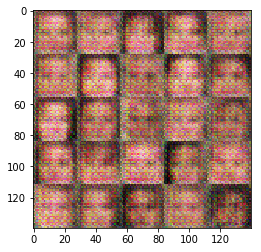

Samples used 52480 Epoch 1/1... Discriminator Loss: 0.8779... Generator Loss: 1.2179
Samples used 53760 Epoch 1/1... Discriminator Loss: 0.5364... Generator Loss: 2.3517
Samples used 55040 Epoch 1/1... Discriminator Loss: 0.5837... Generator Loss: 2.7300
Samples used 56320 Epoch 1/1... Discriminator Loss: 0.6258... Generator Loss: 1.7571
Samples used 57600 Epoch 1/1... Discriminator Loss: 0.6901... Generator Loss: 1.5250
Samples used 58880 Epoch 1/1... Discriminator Loss: 0.4626... Generator Loss: 2.4270
Samples used 60160 Epoch 1/1... Discriminator Loss: 0.5041... Generator Loss: 2.4324
Samples used 61440 Epoch 1/1... Discriminator Loss: 0.3975... Generator Loss: 3.4064
Samples used 62720 Epoch 1/1... Discriminator Loss: 0.4421... Generator Loss: 2.5875
Samples used 64000 Epoch 1/1... Discriminator Loss: 0.3994... Generator Loss: 3.1076
size of z is  (?, 100)
Size of layer 1 (?, 7, 7, 512)
size of output is  (?, 28, 28, 3)


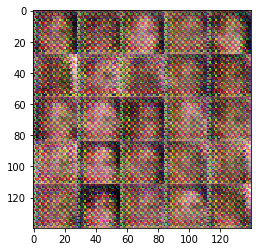

Samples used 65280 Epoch 1/1... Discriminator Loss: 0.4758... Generator Loss: 2.1949
Samples used 66560 Epoch 1/1... Discriminator Loss: 0.4226... Generator Loss: 2.6810
Samples used 67840 Epoch 1/1... Discriminator Loss: 0.3870... Generator Loss: 3.4490
Samples used 69120 Epoch 1/1... Discriminator Loss: 0.6288... Generator Loss: 1.5342
Samples used 70400 Epoch 1/1... Discriminator Loss: 0.4838... Generator Loss: 2.1590
Samples used 71680 Epoch 1/1... Discriminator Loss: 0.4251... Generator Loss: 3.3664
Samples used 72960 Epoch 1/1... Discriminator Loss: 0.9915... Generator Loss: 0.8520
Samples used 74240 Epoch 1/1... Discriminator Loss: 0.5131... Generator Loss: 1.9400
Samples used 75520 Epoch 1/1... Discriminator Loss: 0.3988... Generator Loss: 3.7727
Samples used 76800 Epoch 1/1... Discriminator Loss: 0.3611... Generator Loss: 4.3851
size of z is  (?, 100)
Size of layer 1 (?, 7, 7, 512)
size of output is  (?, 28, 28, 3)


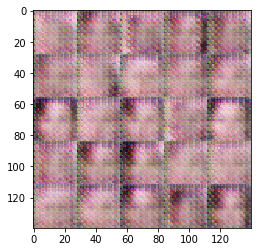

Samples used 78080 Epoch 1/1... Discriminator Loss: 0.3449... Generator Loss: 6.8627
Samples used 79360 Epoch 1/1... Discriminator Loss: 0.3886... Generator Loss: 4.1159
Samples used 80640 Epoch 1/1... Discriminator Loss: 1.1075... Generator Loss: 1.0131
Samples used 81920 Epoch 1/1... Discriminator Loss: 0.5436... Generator Loss: 3.9928
Samples used 83200 Epoch 1/1... Discriminator Loss: 0.3809... Generator Loss: 3.6054
Samples used 84480 Epoch 1/1... Discriminator Loss: 0.5606... Generator Loss: 1.8526
Samples used 85760 Epoch 1/1... Discriminator Loss: 1.9997... Generator Loss: 0.4446
Samples used 87040 Epoch 1/1... Discriminator Loss: 0.6237... Generator Loss: 1.5401
Samples used 88320 Epoch 1/1... Discriminator Loss: 0.5965... Generator Loss: 1.8648
Samples used 89600 Epoch 1/1... Discriminator Loss: 0.5988... Generator Loss: 1.9011
size of z is  (?, 100)
Size of layer 1 (?, 7, 7, 512)
size of output is  (?, 28, 28, 3)


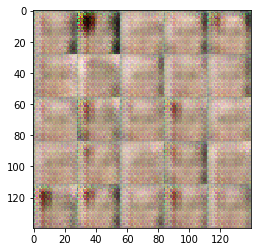

Samples used 90880 Epoch 1/1... Discriminator Loss: 1.6115... Generator Loss: 0.4027
Samples used 92160 Epoch 1/1... Discriminator Loss: 0.6514... Generator Loss: 1.5288
Samples used 93440 Epoch 1/1... Discriminator Loss: 0.4733... Generator Loss: 2.4847
Samples used 94720 Epoch 1/1... Discriminator Loss: 0.5186... Generator Loss: 5.7368
Samples used 96000 Epoch 1/1... Discriminator Loss: 0.4962... Generator Loss: 2.1574
Samples used 97280 Epoch 1/1... Discriminator Loss: 0.4624... Generator Loss: 2.3032
Samples used 98560 Epoch 1/1... Discriminator Loss: 0.9557... Generator Loss: 0.8520
Samples used 99840 Epoch 1/1... Discriminator Loss: 1.8015... Generator Loss: 1.0023
Samples used 101120 Epoch 1/1... Discriminator Loss: 1.8397... Generator Loss: 0.5419
Samples used 102400 Epoch 1/1... Discriminator Loss: 1.4610... Generator Loss: 0.7503
size of z is  (?, 100)
Size of layer 1 (?, 7, 7, 512)
size of output is  (?, 28, 28, 3)


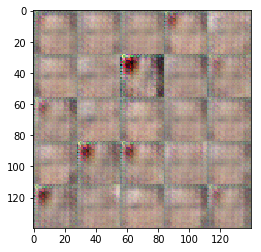

Samples used 103680 Epoch 1/1... Discriminator Loss: 1.4512... Generator Loss: 0.7625
Samples used 104960 Epoch 1/1... Discriminator Loss: 1.4919... Generator Loss: 0.7531
Samples used 106240 Epoch 1/1... Discriminator Loss: 1.5460... Generator Loss: 0.7359
Samples used 107520 Epoch 1/1... Discriminator Loss: 1.4799... Generator Loss: 0.7578
Samples used 108800 Epoch 1/1... Discriminator Loss: 1.4467... Generator Loss: 0.7654
Samples used 110080 Epoch 1/1... Discriminator Loss: 1.5667... Generator Loss: 0.7136
Samples used 111360 Epoch 1/1... Discriminator Loss: 1.5296... Generator Loss: 0.7427
Samples used 112640 Epoch 1/1... Discriminator Loss: 1.5029... Generator Loss: 0.7569
Samples used 113920 Epoch 1/1... Discriminator Loss: 1.4446... Generator Loss: 0.7921
Samples used 115200 Epoch 1/1... Discriminator Loss: 1.4195... Generator Loss: 0.7887
size of z is  (?, 100)
Size of layer 1 (?, 7, 7, 512)
size of output is  (?, 28, 28, 3)


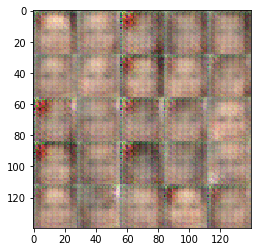

Samples used 116480 Epoch 1/1... Discriminator Loss: 1.4203... Generator Loss: 0.7813
Samples used 117760 Epoch 1/1... Discriminator Loss: 1.3728... Generator Loss: 0.7989
Samples used 119040 Epoch 1/1... Discriminator Loss: 1.4259... Generator Loss: 0.7824
Samples used 120320 Epoch 1/1... Discriminator Loss: 1.3519... Generator Loss: 0.8170
Samples used 121600 Epoch 1/1... Discriminator Loss: 1.3349... Generator Loss: 0.8371
Samples used 122880 Epoch 1/1... Discriminator Loss: 1.2836... Generator Loss: 0.8483
Samples used 124160 Epoch 1/1... Discriminator Loss: 1.3502... Generator Loss: 0.7821
Samples used 125440 Epoch 1/1... Discriminator Loss: 1.3689... Generator Loss: 0.7852
Samples used 126720 Epoch 1/1... Discriminator Loss: 1.3617... Generator Loss: 0.7961
Samples used 128000 Epoch 1/1... Discriminator Loss: 1.4243... Generator Loss: 0.7510
size of z is  (?, 100)
Size of layer 1 (?, 7, 7, 512)
size of output is  (?, 28, 28, 3)


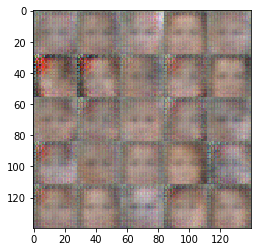

Samples used 129280 Epoch 1/1... Discriminator Loss: 1.3513... Generator Loss: 0.7964
Samples used 130560 Epoch 1/1... Discriminator Loss: 1.3955... Generator Loss: 0.7541
Samples used 131840 Epoch 1/1... Discriminator Loss: 1.4622... Generator Loss: 0.7276
Samples used 133120 Epoch 1/1... Discriminator Loss: 1.4420... Generator Loss: 0.7747
Samples used 134400 Epoch 1/1... Discriminator Loss: 1.4303... Generator Loss: 0.7608
Samples used 135680 Epoch 1/1... Discriminator Loss: 1.4043... Generator Loss: 0.8028
Samples used 136960 Epoch 1/1... Discriminator Loss: 1.4108... Generator Loss: 0.7975
Samples used 138240 Epoch 1/1... Discriminator Loss: 1.4131... Generator Loss: 0.7830
Samples used 139520 Epoch 1/1... Discriminator Loss: 1.4853... Generator Loss: 0.7415
Samples used 140800 Epoch 1/1... Discriminator Loss: 1.4004... Generator Loss: 0.7903
size of z is  (?, 100)
Size of layer 1 (?, 7, 7, 512)
size of output is  (?, 28, 28, 3)


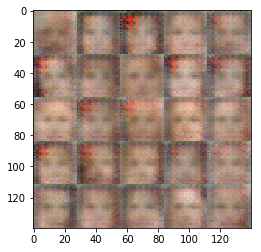

Samples used 142080 Epoch 1/1... Discriminator Loss: 1.4255... Generator Loss: 0.7795
Samples used 143360 Epoch 1/1... Discriminator Loss: 1.4255... Generator Loss: 0.7914
Samples used 144640 Epoch 1/1... Discriminator Loss: 1.3840... Generator Loss: 0.8176
Samples used 145920 Epoch 1/1... Discriminator Loss: 1.3526... Generator Loss: 0.8249
Samples used 147200 Epoch 1/1... Discriminator Loss: 1.3830... Generator Loss: 0.7963
Samples used 148480 Epoch 1/1... Discriminator Loss: 1.4367... Generator Loss: 0.7815
Samples used 149760 Epoch 1/1... Discriminator Loss: 1.3516... Generator Loss: 0.7880
Samples used 151040 Epoch 1/1... Discriminator Loss: 1.3722... Generator Loss: 0.8076
Samples used 152320 Epoch 1/1... Discriminator Loss: 1.3795... Generator Loss: 0.7765
Samples used 153600 Epoch 1/1... Discriminator Loss: 1.4185... Generator Loss: 0.7768
size of z is  (?, 100)
Size of layer 1 (?, 7, 7, 512)
size of output is  (?, 28, 28, 3)


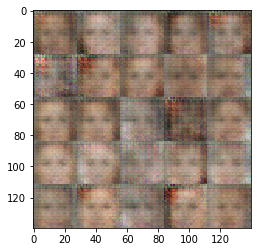

Samples used 154880 Epoch 1/1... Discriminator Loss: 1.3473... Generator Loss: 0.8222
Samples used 156160 Epoch 1/1... Discriminator Loss: 1.4111... Generator Loss: 0.7852
Samples used 157440 Epoch 1/1... Discriminator Loss: 1.3750... Generator Loss: 0.7980
Samples used 158720 Epoch 1/1... Discriminator Loss: 1.4502... Generator Loss: 0.7472
Samples used 160000 Epoch 1/1... Discriminator Loss: 1.4264... Generator Loss: 0.7601
Samples used 161280 Epoch 1/1... Discriminator Loss: 1.3983... Generator Loss: 0.7858
Samples used 162560 Epoch 1/1... Discriminator Loss: 1.4040... Generator Loss: 0.7986
Samples used 163840 Epoch 1/1... Discriminator Loss: 1.3788... Generator Loss: 0.7879
Samples used 165120 Epoch 1/1... Discriminator Loss: 1.4242... Generator Loss: 0.7675
Samples used 166400 Epoch 1/1... Discriminator Loss: 1.3867... Generator Loss: 0.8031
size of z is  (?, 100)
Size of layer 1 (?, 7, 7, 512)
size of output is  (?, 28, 28, 3)


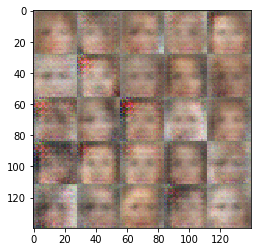

Samples used 167680 Epoch 1/1... Discriminator Loss: 1.4461... Generator Loss: 0.7428
Samples used 168960 Epoch 1/1... Discriminator Loss: 1.3878... Generator Loss: 0.7546
Samples used 170240 Epoch 1/1... Discriminator Loss: 1.4472... Generator Loss: 0.7725
Samples used 171520 Epoch 1/1... Discriminator Loss: 1.3513... Generator Loss: 0.8051
Samples used 172800 Epoch 1/1... Discriminator Loss: 1.4028... Generator Loss: 0.7547
Samples used 174080 Epoch 1/1... Discriminator Loss: 1.4101... Generator Loss: 0.7647
Samples used 175360 Epoch 1/1... Discriminator Loss: 1.3778... Generator Loss: 0.7922
Samples used 176640 Epoch 1/1... Discriminator Loss: 1.3901... Generator Loss: 0.7880
Samples used 177920 Epoch 1/1... Discriminator Loss: 1.4015... Generator Loss: 0.7817
Samples used 179200 Epoch 1/1... Discriminator Loss: 1.4384... Generator Loss: 0.7645
size of z is  (?, 100)
Size of layer 1 (?, 7, 7, 512)
size of output is  (?, 28, 28, 3)


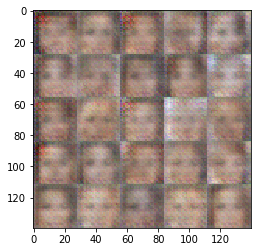

Samples used 180480 Epoch 1/1... Discriminator Loss: 1.4482... Generator Loss: 0.7666
Samples used 181760 Epoch 1/1... Discriminator Loss: 1.3730... Generator Loss: 0.7952
Samples used 183040 Epoch 1/1... Discriminator Loss: 1.3978... Generator Loss: 0.7912
Samples used 184320 Epoch 1/1... Discriminator Loss: 1.3997... Generator Loss: 0.7614
Samples used 185600 Epoch 1/1... Discriminator Loss: 1.3780... Generator Loss: 0.8027
Samples used 186880 Epoch 1/1... Discriminator Loss: 1.4195... Generator Loss: 0.7753
Samples used 188160 Epoch 1/1... Discriminator Loss: 1.4249... Generator Loss: 0.7914
Samples used 189440 Epoch 1/1... Discriminator Loss: 1.4205... Generator Loss: 0.7913
Samples used 190720 Epoch 1/1... Discriminator Loss: 1.3858... Generator Loss: 0.7854
Samples used 192000 Epoch 1/1... Discriminator Loss: 1.3821... Generator Loss: 0.8008
size of z is  (?, 100)
Size of layer 1 (?, 7, 7, 512)
size of output is  (?, 28, 28, 3)


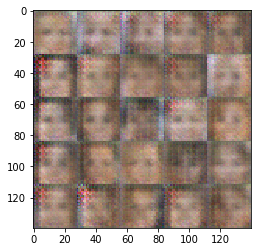

Samples used 193280 Epoch 1/1... Discriminator Loss: 1.3764... Generator Loss: 0.7873
Samples used 194560 Epoch 1/1... Discriminator Loss: 1.3743... Generator Loss: 0.8076
Samples used 195840 Epoch 1/1... Discriminator Loss: 1.4606... Generator Loss: 0.7479
Samples used 197120 Epoch 1/1... Discriminator Loss: 1.3881... Generator Loss: 0.7949
Samples used 198400 Epoch 1/1... Discriminator Loss: 1.3792... Generator Loss: 0.7904
Samples used 199680 Epoch 1/1... Discriminator Loss: 1.3983... Generator Loss: 0.7721
Samples used 200960 Epoch 1/1... Discriminator Loss: 1.3908... Generator Loss: 0.7767
Samples used 202240 Epoch 1/1... Discriminator Loss: 1.3626... Generator Loss: 0.7831
Done with the training..Enjoy your pictures


IndexError: list index out of range

In [24]:
batch_size = int(128) #128 #None
z_dim = 100 #100 #None
learning_rate = 0.0002 #None
beta1 = 0.5 #1e-4 #0.1# None


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.